In [1]:
# Set up
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings("ignore")

### 7.8

### (a)

In [2]:
df_retail=pd.read_excel('retail.xlsx')
df_retail['Date']= pd.to_datetime(df_retail['Date'])
df_retail.set_index('Date',inplace=True)
df_retail_all = df_retail['Turnover ;  New South Wales ;  Total (Industry) ;']
df_retail_all

Date
1982-04-01    1250.2
1982-05-01    1300.0
1982-06-01    1234.2
1982-07-01    1265.0
1982-08-01    1217.6
               ...  
2013-08-01    6675.2
2013-09-01    6604.1
2013-10-01    7026.9
2013-11-01    7391.1
2013-12-01    9185.3
Name: Turnover ;  New South Wales ;  Total (Industry) ;, Length: 381, dtype: float64

Text(0, 0.5, 'Sales')

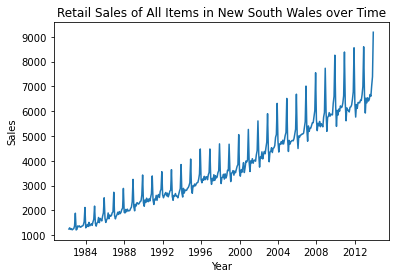

In [3]:
plt.plot(df_retail_all)
plt.title('Retail Sales of All Items in New South Wales over Time')
plt.xlabel('Year')
plt.ylabel('Sales')

From above plot, we can see that the magnitude of the seasonal pattern changes as the series evolves. Since the seasonal variation becomes larger as the year of the series increases, multiplicative seasonality can capture this relationship more accurately. Multiplicative seasonality allows for a proportional change in the seasonal effect as the series values change and it is necessary for this series.

### (b)

In [4]:
model_hw_undam = ExponentialSmoothing(df_retail_all, trend="mul", damped=False).fit()
model_hw_dam = ExponentialSmoothing(df_retail_all, trend="mul", damped=True).fit()

### (c)

In [5]:
# Split the data into training and testing sets
train_data_hw = df_retail_all[:-1]  # Use all data except the last point for training
test_data_hw = df_retail_all[-1:]  # Use the last point as the test data

In [6]:
##RMSE of undamped Holt-Winters Model

# Fit the Holt-Winters' model to the training data
model_hw_undam1 = ExponentialSmoothing(train_data_hw, trend="mul", damped=False).fit()

# Generate a one-step forecast for the testing data
forecast_hw_undam1 = model_hw_undam1.forecast(steps=1)

# Calculate RMSE
mse_hw_undam1 = mean_squared_error(test_data_hw, forecast_hw_undam1)
rmse_hw_undam1 = np.sqrt(mse_hw_undam1)


##RMSE of damped Holt-Winters Model

# Fit the Holt-Winters' model to the training data
model_hw_dam1 = ExponentialSmoothing(train_data_hw, trend="mul", damped=True).fit()

# Generate a one-step forecast for the testing data
forecast_hw_dam1 = model_hw_dam1.forecast(steps=1)

# Calculate RMSE
mse_hw_dam1 = mean_squared_error(test_data_hw, forecast_hw_dam1)
rmse_hw_dam1 = np.sqrt(mse_hw_dam1)

print("RMSE of undamped Holt-Winters Model:", rmse_hw_undam1)
print("RMSE of damped Holt-Winters Model:", rmse_hw_dam1)

RMSE of undamped Holt-Winters Model: 2344.8753594456866
RMSE of damped Holt-Winters Model: 2381.7913140007295


Since the RMSE of undamped Holt-Winters model is smaller, I prefer undamped Holt-Winters model.

### (d)

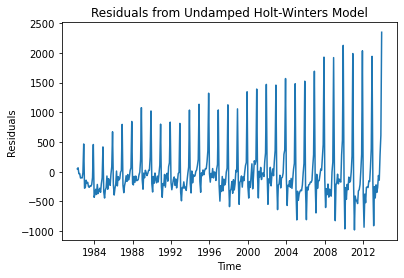

In [7]:
# Generate predictions for the data
predictions_hw_undam = model_hw_undam.fittedvalues

# Calculate the residuals
residuals_hw_undam = df_retail_all - predictions_hw_undam

# Plot the residuals
plt.plot(residuals_hw_undam)
plt.title("Residuals from Undamped Holt-Winters Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

Even though it seems that the magnitude of the residuals above is increasing as time passes by, there is no significant structure of the residuals, indicating that the residuals resemble white noise.

### (e)

In [8]:
train_data_hw1 = df_retail_all[:'2010-12-01']
test_data_hw1 = df_retail_all['2011-01-01':]

In [9]:
##RMSE of undamped Holt-Winters Model

# Fit the Holt-Winters' model to the training data
model_hw_undam2 = ExponentialSmoothing(train_data_hw1, trend="mul", damped=False).fit()

# Generate forecasts for the testing data
forecast_hw_undam2 = model_hw_undam2.forecast(steps=len(test_data_hw1))

# Calculate RMSE
mse_hw_undam2 = mean_squared_error(test_data_hw1, forecast_hw_undam2)
rmse_hw_undam2 = np.sqrt(mse_hw_undam2)

In [10]:
##RMSE of the seasonal naïve approach

# Fit the seasonal naïve approach to the training data
model_hw_undam3 = ExponentialSmoothing(train_data_hw1, seasonal='add', seasonal_periods=12).fit()

# Generate forecasts for the testing data
forecast_hw_undam3 = model_hw_undam3.forecast(steps=len(test_data_hw1))

# Calculate RMSE
mse_hw_undam3 = mean_squared_error(test_data_hw1, forecast_hw_undam3)
rmse_hw_undam3 = np.sqrt(mse_hw_undam3)

In [11]:
print("RMSE of undamped Holt-Winters Model:", rmse_hw_undam2)
print("RMSE of the seasonal naïve approach:", rmse_hw_undam3)

RMSE of undamped Holt-Winters Model: 883.6073536876124
RMSE of the seasonal naïve approach: 329.47229594548116


Since the RMSE of the seasonal naïve approach is smaller, I cannot beat the seasonal naïve approach.

### 7.9

In [12]:
# Perform STL decomposition on the Box-Cox transformed series
transformed_train, lambda_value = stats.boxcox(train_data_hw1)
transformed_train = pd.Series(transformed_train, index=train_data_hw1.index)
decomposition = seasonal_decompose(transformed_train, model='multiplicative', extrapolate_trend='freq')

# Obtain the seasonally adjusted component from the decomposition
seasonally_adjusted = decomposition.resid

# Fit ETS model on the seasonally adjusted data
model_ets = ETSModel(seasonally_adjusted, error='add', trend='add',
                     damped_trend=False, seasonal='add', seasonal_periods=13).fit()

# Make forecasts on the test set
fc = model_ets.forecast(len(test_data_hw1))

# Inverse transform the forecasts using the Box-Cox transformation
inv_fc = inv_boxcox(fc, lambda_value)

# Calculate RMSE
mse_ets = mean_squared_error(test_data_hw1, inv_fc)
rmse_ets = np.sqrt(mse_ets)

print("RMSE of ETS Model:", rmse_ets)
print("RMSE of the seasonal naïve approach:", rmse_hw_undam3)

RMSE of ETS Model: 6623.328519183246
RMSE of the seasonal naïve approach: 329.47229594548116


The ETS model has much higher RMSE compared to the RMSE of the best previous forecast on the test set, so I think the previous model is still better.